# Image Classifiction using CNNs

## Exploring the CIFAR10 Dataset

In the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we trained a feedfoward neural networks with a single hidden layer to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist) with over 97% accuracy. For this tutorial, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

In [1]:
import os
import torch
import tarfile
import torchvision
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url

In [2]:
with tarfile.open('./data/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory `data/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [3]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'horse', 'cat', 'frog', 'truck', 'bird', 'ship', 'dog', 'deer', 'automobile']


Let's look inside a couple of folders, one from the training set and another from the test set. As an exercise, you can verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [4]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['1354.png', '0390.png', '1717.png', '3775.png', '4242.png']


In [5]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0390.png', '0400.png', '0327.png', '0955.png', '0097.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [8]:
img, label = dataset[0]
print(img.shape, label, len(dataset))
img

torch.Size([3, 32, 32]) 0 50000


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [9]:
def show_example(img, label):
    print(f"Label: {dataset.classes[label], ({label})}")
    plt.imshow(img.permute(1, 2, 0))    

Label: ('airplane', {0})


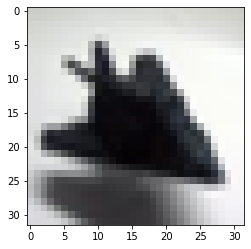

In [10]:
show_example(*dataset[0])

Label: ('bird', {2})


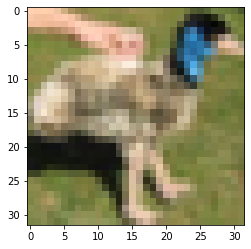

In [11]:
show_example(*dataset[10099])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [12]:
random_seed = 42
torch.manual_seed(random_seed)

In [13]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [14]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=False, num_workers=4, pin_memory=True)

In [15]:
for img, lbl in train_dl:
    print(img.shape, lbl)
    break

torch.Size([128, 3, 32, 32]) tensor([8, 8, 6, 9, 9, 3, 6, 8, 7, 3, 6, 5, 4, 1, 9, 1, 5, 8, 2, 1, 3, 0, 1, 7,
        0, 5, 5, 7, 3, 2, 8, 6, 0, 0, 3, 5, 2, 6, 5, 9, 3, 7, 2, 2, 5, 9, 2, 5,
        4, 3, 3, 0, 9, 8, 7, 1, 4, 2, 2, 7, 7, 4, 1, 2, 6, 3, 8, 9, 0, 6, 7, 6,
        6, 0, 0, 6, 8, 1, 5, 5, 8, 4, 6, 9, 2, 7, 2, 3, 0, 8, 8, 2, 6, 7, 5, 8,
        6, 7, 9, 2, 3, 7, 3, 6, 1, 4, 7, 5, 3, 6, 1, 5, 6, 5, 4, 1, 3, 9, 5, 0,
        9, 0, 6, 6, 3, 8, 4, 2])


In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

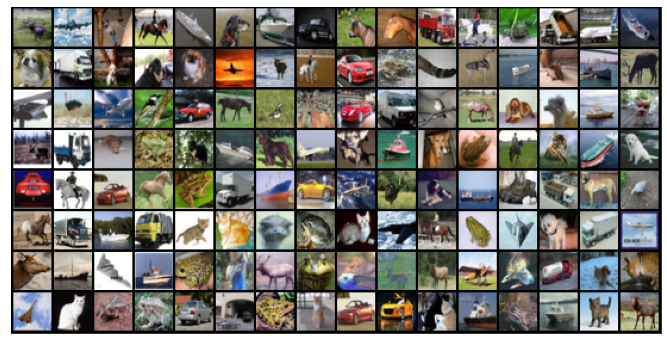

In [17]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

In our [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we defined a deep neural network with fully-connected layers using `nn.Linear`. For this tutorial however, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [18]:
def apply_kernel(image, kernel):
    # both image and kernel are essentially matrices
    ri, ci = image.shape        # Image Dimensions
    rk, ck = kernel.shape       # kernel dimension
    ro, co = ri-rk+1, ci-ck+1   # output dimension
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i][j] = torch.sum(image[i:i+rk, j:j+ck]*kernel)
            
    return output
    

In [19]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

Lets See how convolutions work for multiple channels in a colour image.
- Each of the kernels of the filter “slides” over their respective input channels, producing a processed version of each. Some kernels may have stronger weights than others, to give more emphasis to certain input channels than others (eg. a filter may have a red kernel channel with stronger weights than others, and hence, respond more to differences in the red channel features than the others).

![](https://miro.medium.com/max/2000/1*8dx6nxpUh2JqvYWPadTwMQ.gif)

- Each of the per-channel processed versions are then summed together to form one channel. The kernels of a filter each produce one version of each channel, and the filter as a whole produces one overall output channel.

![](https://miro.medium.com/max/2000/1*CYB2dyR3EhFs1xNLK8ewiA.gif)

- Finally, then there’s the bias term. The way the bias term works here is that each output filter has one bias term. The bias gets added to the output channel so far to produce the final output channel.

![](https://miro.medium.com/max/588/1*RYYucIh3U-YFxrIkyQKzRw.gif)



In [20]:
import torch.nn.functional as F 

In [21]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2) # Reduces image size to row/2, col/2
)

In [22]:
for images, labels in train_dl:
    print('Shape: ', images.shape)
    out = simple_model(images)
    print('output shape: ', out.shape)
    break

Shape:  torch.Size([128, 3, 32, 32])
output shape:  torch.Size([128, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
        
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
# A quick reminder on how torch.max functions
a = torch.randn(4, 4)
a

tensor([[ 0.1966, -0.0673,  0.3666, -0.5788],
        [ 0.4766, -0.0754, -0.3005, -0.8730],
        [ 1.1483,  0.1499, -0.4069, -1.0599],
        [ 0.8562, -1.5801, -0.4065,  1.2669]])

In [25]:
_, p = torch.max(a, dim=1)
p 


tensor([2, 0, 0, 3])


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [26]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output 64 x 16 x 16
            nn.BatchNorm2d()
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [27]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. Check out [Part 3 (logistic regression)](https://jovian.ml/aakashns/03-logistic-regression#C50) for a more detailed discussion on interpeting the outputs, applying softmax and identifying the predicted labels.

In [28]:
for images, labels in train_dl:
    print("Images Shape: ", images.shape)
    out = model(images)
    print("Output Shape: ", out.shape)
    print("Out[0]: ", out[0])
    break

Images Shape:  torch.Size([128, 3, 32, 32])
Output Shape:  torch.Size([128, 10])
Out[0]:  tensor([ 0.0267, -0.0265, -0.0460,  0.0132, -0.0314,  0.0179, -0.0398, -0.0248,
         0.0094, -0.0052], grad_fn=<SelectBackward0>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [30]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()     # Calculate Gradients
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [33]:
# model = to_device(CnnModel(), device)

In [34]:
evaluate(model, train_dl)

{'val_loss': tensor(2.3030, device='cuda:0'), 'val_acc': tensor(0.0995)}

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [35]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001 

In [36]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6995, val_loss: 1.3002, val_acc: 0.5190
Epoch [1], train_loss: 1.1532, val_loss: 1.0160, val_acc: 0.6376
Epoch [2], train_loss: 0.9032, val_loss: 0.8643, val_acc: 0.6958
Epoch [3], train_loss: 0.7329, val_loss: 0.7903, val_acc: 0.7265
Epoch [4], train_loss: 0.5940, val_loss: 0.7781, val_acc: 0.7399
Epoch [5], train_loss: 0.4800, val_loss: 0.7611, val_acc: 0.7561
Epoch [6], train_loss: 0.3698, val_loss: 0.7604, val_acc: 0.7675
Epoch [7], train_loss: 0.2770, val_loss: 0.8899, val_acc: 0.7602
Epoch [8], train_loss: 0.2213, val_loss: 0.9428, val_acc: 0.7666
Epoch [9], train_loss: 0.1721, val_loss: 1.1028, val_acc: 0.7429


In [65]:
def plot(history):
    fig, ax1 = plt.subplots()
    accuracies = [x['val_acc'] for x in history]
    ax1.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.title('Accuracy vs No. of Epochs')
    
    fig, ax2 = plt.subplots()
    losses = [x['val_loss'].cpu() for x in history]
    ax2.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Losses')
    plt.title('Losses vs No. of Epochs')
    
    t_losses = [x['train_loss'] for x in history]
    ax2.plot(t_losses, '-rx')
    plt.legend(['Training', 'Validation'])

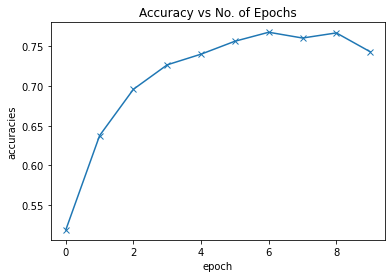

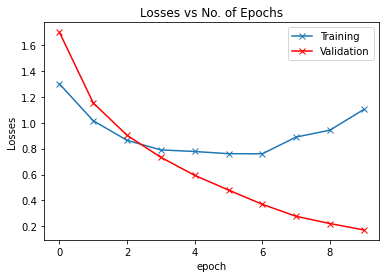

In [66]:
plot(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase

We will cover these topics in more detail in the next tutorial in this series, and learn how we can reach an accuracy of **over 90%** by making minor but important changes to our model.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.


In [68]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [69]:
def predict_image(image, model):
    # Convert to a Batch of 1
    xb = to_device(image.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick the appropriate index
    _, preds = torch.max(yb, dim=1)
    # retrieve class label
    return dataset.classes[preds[0].item()]

Label: airplane, Predicted: airplane


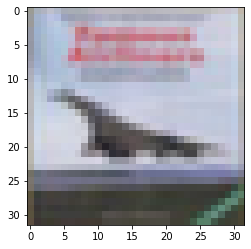

In [70]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print(f"Label: {dataset.classes[label]}, Predicted: {predict_image(img, model)}")

Label: automobile , Predicted: automobile


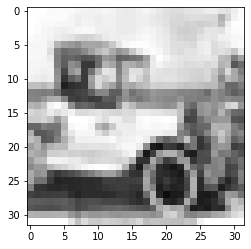

In [71]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


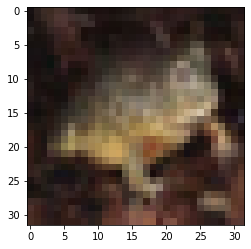

In [72]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [73]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': tensor(1.1674, device='cuda:0'), 'val_acc': tensor(0.7315)}

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [75]:
torch.save(model.state_dict(), './model/cifar10-cnn.pth')

In [76]:
model2 = to_device(CnnModel(), device)

In [77]:
model2.load_state_dict(torch.load('./model/cifar10-cnn.pth'))

<All keys matched successfully>

In [78]:
# Verifying the model has been loaded
evaluate(model2, test_loader)

{'val_loss': tensor(1.1674, device='cuda:0'), 'val_acc': tensor(0.7315)}

## Summary and Further Reading/Exercises

We've covered a lot of ground in this tutorial. Here's quick recap of the topics:
* Introduction to the CIFAR10 dataset for image classification
* Downloading, extracing and loading an image dataset using `torchvision`
* Show random batches of images in a grid using `torchvision.utils.make_grid`
* Creating a convolutional neural network using with `nn.Conv2d` and `nn.MaxPool2d` layers
* Capturing dataset information, metrics and hyperparameters using the `jovian` library
* Training a convolutional neural network and visualizing the losses and errors
* Understanding overfitting and the strategies for avoiding it (more on this later)
* Generating predictions on single images from the test set
* Saving and loading the model weights, and attaching them to the eperiment snaptshot using `jovian`

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:
* Try chaging the hyperparameters to achieve a higher accuracy within fewer epochs. You use the comparison table on the Jovian.ml project page to compare your experiments.
* Try adding more convolutional layers, or increasing the number of channels in each convolutional layer
* Try using a feedforward neural network and see what's the maximum accuracy you can achieve
* Read about some of the startegies mentioned above for reducing overfitting and achieving better results, and try to implement them by looking into the PyTorch docs.
* Modify this notebook to train a model for a different dataset (e.g. CIFAR100 or ImageNet)

In the next tutorial, we will continue to improve our model's accuracy using techniques like data augmentation, batch normalization and dropout. We will also learn about residual networks (or ResNets), a small but critical change to the model architecture that will significantly boost the performance of our model. Stay tuned!